In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import os
from shapely.geometry import Polygon

In [8]:
data = pd.read_parquet('/home/praneeth/Desktop/eye_pop_assignment/ep-sai-praneeth-potladurthy/data/dataset.parquet')
img_path = os.path.join(os.getcwd(), data['asset_url'].iloc[0])
annotations = data['annotations'].iloc[0][0]

In [ ]:
annotations

In [9]:
def draw_polygon_from_keypoints(image, keypoints, options=None):
    if options is None:
        options = {}
    
    # Default options
    line_color = options.get('line_color', (0, 255, 0))
    line_thickness = options.get('line_thickness', 2)
    point_color = options.get('point_color', (0, 0, 255))
    point_radius = options.get('point_radius', 4)
    fill_polygon = options.get('fill_polygon', False)
    fill_color = options.get('fill_color', (0, 255, 0))
    fill_alpha = options.get('fill_alpha', 0.3)
    show_point_numbers = options.get('show_point_numbers', False)
    
    result_image = image.copy()
    
    if len(keypoints) < 3:
        return result_image
    
    # Convert to numpy array for OpenCV functions
    pts = np.array(keypoints, np.int32)
    
    # Fill polygon if requested
    if fill_polygon:
        overlay = result_image.copy()
        cv2.fillPoly(overlay, [pts], fill_color)
        result_image = cv2.addWeighted(result_image, 1 - fill_alpha, overlay, fill_alpha, 0)
    
    # Draw polygon outline
    # cv2.polylines(result_image, [pts], True, line_color, line_thickness)
    return result_image

In [10]:
def extract_key_points(annotations, image_width, image_height):
    all_tile_keypoints = []
    for tile in annotations['objects']:
        keypoints_array = tile['keyPoints']
        # Extract points from each keypoint object
        pixel_points = []
        for point in keypoints_array[0]['points']:
            # Convert normalized coordinates to pixel coordinates
            pixel_x = int(point['x'] * image_width)
            pixel_y = int(point['y'] * image_height)
            pixel_points.append((pixel_x, pixel_y))
        all_tile_keypoints.append(pixel_points)
    
    return all_tile_keypoints

In [11]:
def process_image(image_path, annotations):
    # Load image
    image = cv2.imread(image_path)
    cv2.imshow
    image_height, image_width = image.shape[:2]
    
    # Extract keypoints
    keypoints = extract_key_points(annotations, image_width, image_height)
    options = {
                'line_color': (0, 255, 0),
                'line_thickness': 2,
                'point_color': (0, 0, 255),
                'point_radius': 4,
                'fill_polygon': True,
                'fill_color': (0, 255, 0),
                'fill_alpha': 0.3,
                'show_point_numbers': True
            }
    print('Keypoints extracted:', keypoints)
    # Draw polygons for each set of keypoints
    for points in keypoints:
        image = draw_polygon_from_keypoints(image, points, options)
    
    return image

In [12]:
img = process_image(img_path, annotations)

Keypoints extracted: [[(3, 0), (218, 1), (217, 65), (1, 64)], [(54, 100), (54, 195), (1, 247), (1, 153)], [(53, 195), (108, 243), (113, 164), (56, 101)], [(104, 256), (53, 199), (1, 253)], [(227, 260), (110, 256), (115, 160), (57, 100), (3, 145), (1, 66), (218, 69)], [(297, 80), (295, 135), (472, 136), (473, 80), (406, 76), (350, 125)], [(475, 77), (494, 63), (415, 64), (409, 74)], [(411, 2), (412, 63), (492, 60), (494, 0)], [(499, 67), (475, 80), (473, 204), (426, 152), (424, 229), (473, 231), (498, 265)], [(296, 136), (302, 227), (353, 227), (427, 154), (475, 200), (473, 138)], [(427, 161), (424, 227), (384, 229), (350, 256), (348, 229)], [(350, 261), (494, 263), (475, 234), (384, 230)], [(353, 0), (353, 120), (412, 66), (414, 0)], [(354, 0), (273, 0), (274, 176), (295, 177), (297, 80), (350, 120)], [(550, 0), (562, 0), (573, 13), (574, 136), (606, 100), (605, 245), (558, 248), (547, 258)], [(573, 71), (640, 72), (640, 138), (608, 102), (576, 131)], [(563, 0), (639, 3), (638, 67), (5

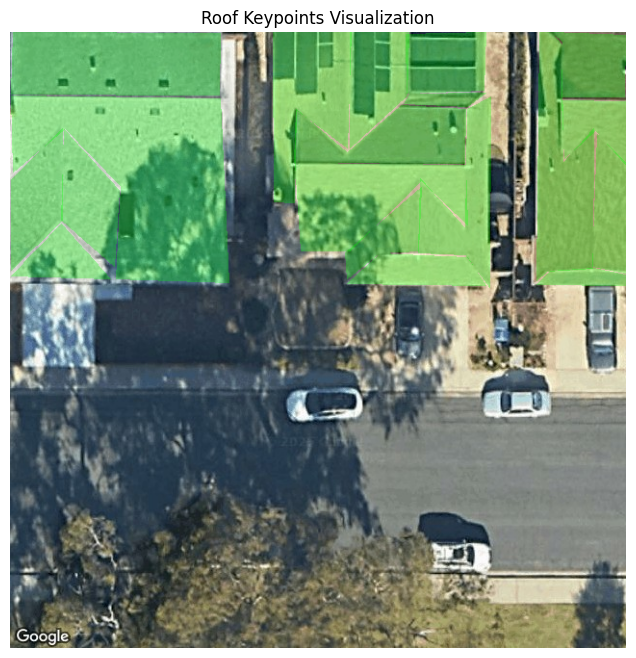

In [13]:
# Display the image with annotations
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.title('Roof Keypoints Visualization')
plt.axis('off')
plt.show()

In [ ]:
a = np.load('outputs/val_ground_truth.npy', allow_pickle=True)

for i in range(len(a)):
    print(a[i])
    print('-------------------'*100)
    print('\n')

In [ ]:
def polygon_iou(pred_points, gt_points):
    """Calculate IoU between two polygons"""
    try:
        pred_coords = [(p['x'], p['y']) for p in pred_points if len(pred_points) > 0]
        gt_coords = [(p['x'], p['y']) for p in gt_points if len(gt_points) > 0]
        
        if len(pred_coords) < 3 or len(gt_coords) < 3:
            return 0.0
        
        pred_poly = Polygon(pred_coords)
        gt_poly = Polygon(gt_coords)
        
        if not pred_poly.is_valid or not gt_poly.is_valid:
            return 0.0
        
        intersection = pred_poly.intersection(gt_poly).area
        union = pred_poly.union(gt_poly).area
        return intersection / union if union > 0 else 0.0
    except:
        return 0.0

In [ ]:
def get_metrics():
    total_gt, total_pred, matched, total_iou = 0, 0, 0, 0.0

    for gt, pred in zip(np.load('outputs/val_ground_truth.npy', allow_pickle=True), 
                        np.load('outputs/val_predictions.npy', allow_pickle=True)):

        pred_objs = pred.get('objects', [])
        gt_objs = gt.get('objects', [])

        total_pred += len(pred_objs)
        total_gt += len(gt_objs)

        gt_matched = set()
        pred_matched = set()

        # Compute IoU for every pair and match greedily
        iou_matrix = np.zeros((len(pred_objs), len(gt_objs)))
        for i, pred_obj in enumerate(pred_objs):
            pred_keypoints = pred_obj.get('keyPoints', [])
            if not pred_keypoints:
                continue
            pred_points = pred_keypoints[0].get('points', [])
            for j, gt_obj in enumerate(gt_objs):
                gt_keypoints = gt_obj.get('keyPoints', [])
                if not gt_keypoints:
                    continue
                gt_points = gt_keypoints[0].get('points', [])
                iou_matrix[i, j] = polygon_iou(pred_points, gt_points)

        # Greedy matching
        while True:
            max_iou = 0
            max_idx = (-1, -1)
            for i in range(len(pred_objs)):
                if i in pred_matched:
                    continue
                for j in range(len(gt_objs)):
                    if j in gt_matched:
                        continue
                    if iou_matrix[i, j] > max_iou:
                        max_iou = iou_matrix[i, j]
                        max_idx = (i, j)
            if max_iou >= 0.7:
                matched += 1
                total_iou += max_iou
                pred_matched.add(max_idx[0])
                gt_matched.add(max_idx[1])
            else:
                break

    precision = matched / total_pred if total_pred > 0 else 0.0
    recall = matched / total_gt if total_gt > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    mean_iou = total_iou / matched if matched > 0 else 0.0

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_iou': mean_iou,
        'total_predicted_roofs': total_pred,
        'total_ground_truth_roofs': total_gt,
        'matched_roofs': matched
    }

In [ ]:
get_metrics()

In [ ]:
def get_metrics():
    total_gt, total_pred, matched, total_iou = 0, 0, 0, 0.0
    for gt,pred in zip(np.load('outputs/val_ground_truth.npy', allow_pickle=True), 
                       np.load('outputs/val_predictions.npy', allow_pickle=True)):

        pred_objs = pred.get('objects', [])
        gt_objs = gt.get('objects', [])

        for pred_obj, gt_obj in zip(pred_objs, gt_objs):  # for evry roof

            pred_keypoints = pred_obj.get('keyPoints', [])
            gt_keypoints = gt_obj.get('keyPoints', [])

            best_iou = 0.0
            
            if len(pred_keypoints) == 0:
                continue
            
            pred_points = pred_keypoints[0].get('points', [])  # multiple points that corerspond to a single polygon
            gt_points = gt_keypoints[0].get('points', [])

            if len(gt_keypoints) == 0:
                continue

            total_gt += len(gt_points)
            total_pred += len(pred_points)

            iou = polygon_iou(pred_points, gt_points)
            best_iou = max(best_iou, iou)
            
            if best_iou >= 0.7:
                matched += 1
                total_iou += best_iou
    
    precision = matched / total_pred if total_pred > 0 else 0.0
    recall = matched / total_gt if total_gt > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    mean_iou = total_iou / matched if matched > 0 else 0.0
    
    return {
        'precision': precision, 'recall': recall, 'f1_score': f1_score,
        'mean_iou': mean_iou, 'total_predictions': total_pred,
        'total_ground_truth': total_gt, 'matched_objects': matched
    }